In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder,OneHotEncoder,StandardScaler
from sklearn.model_selection import cross_val_score,KFold

pd.set_option('display.max_columns',None)
import warnings
warnings.filterwarnings('ignore')
sns.set(style='whitegrid')
sns.set(rc={'font.weight':'bold'})

In [2]:
train=pd.read_csv('C:\\Users\\kanis\\Desktop\\Dataset\\Titanic\\titanic train.csv')
test=pd.read_csv('C:\\Users\\kanis\\Desktop\\Dataset\\Titanic\\titanic test.csv')
ID=test['PassengerId']

In [3]:
df=pd.concat([train,test],ignore_index=True)

### Filling Missing Values in Age 

In [4]:
age_corr=df.corr().abs().unstack().sort_values(ascending=False).reset_index()
age_corr[age_corr['level_0']=='Age']

,level_0,level_1,0
5,Age,Age,1.000000
9,Age,Pclass,0.408106
18,Age,SibSp,0.243699
22,Age,Fare,0.178740
25,Age,Parch,0.150917
30,Age,Survived,0.077221
42,Age,PassengerId,0.028814


In [5]:
print(df.groupby(['Pclass','Sex']).median()['Age'])
df['Age'] = df.groupby(['Sex', 'Pclass'])['Age'].apply(lambda x: x.fillna(x.median()))

Pclass  Sex   
1       female    36.0
        male      42.0
2       female    28.0
        male      29.5
3       female    22.0
        male      25.0
Name: Age, dtype: float64


### Filling Missing values in Embarked

In [6]:
display(df[df['Embarked'].isnull()])
df['Embarked']=df['Embarked'].fillna('S')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1.0,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1.0,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


### Filling Missing values in Fare

In [7]:
display(df[df['Fare'].isnull()])
fare_fill=df.groupby(['Pclass','Parch']).median()['Fare'][3][0]
df['Fare']=df['Fare'].fillna(fare_fill)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1043,1044,NaN,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S


### Adding Deck Column

In [8]:
df['Deck']=df['Cabin'].str[0]
df['Deck']=df['Deck'].fillna('M')

In [9]:
deck_size=df.groupby(['Deck','Pclass']).size().unstack().fillna(0)
deck_viz=deck_size.div(deck_size.sum(axis=1),axis=0)*100

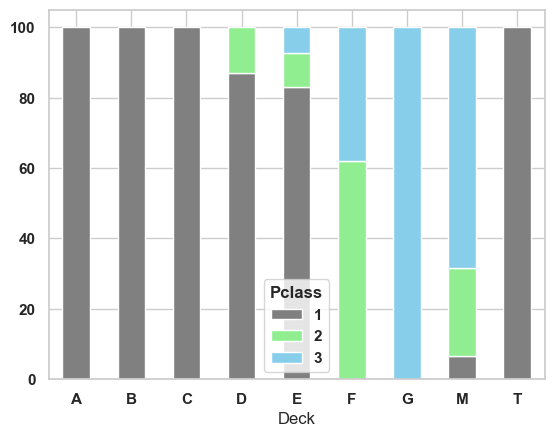

In [10]:
sns.set(style='whitegrid')
deck_viz.plot(kind='bar',stacked=True,color=['grey','lightgreen','skyblue'])
plt.xticks(rotation=0)
plt.show()

In [11]:
deck_survive=df.groupby(['Survived','Deck']).size().unstack().transpose().fillna(0)
deck_survive_viz=deck_survive[:-1].div(deck_survive.sum(axis=1),axis=0)*100

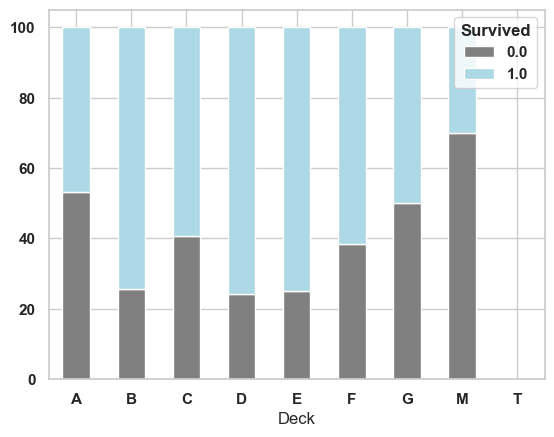

In [12]:
deck_survive_viz.plot(kind='bar',stacked=True,color=['grey','lightblue'])
plt.xticks(rotation=0)
plt.show()

In [13]:
df['Deck']=df['Deck'].replace(['A','B','C','T'],'ABC')
df['Deck']=df['Deck'].replace(['D','E'],'DE')
df['Deck']=df['Deck'].replace(['F','G'],'FG')

In [14]:
df=df.drop(['Cabin'],axis=1)

In [15]:
train=df[:891]
test=df[891:].drop(['Survived'],axis=1)

In [16]:
surv=df[df['Survived']==1]['Survived'].count()/len(train)*100
not_surv=df[df['Survived']==0]['Survived'].count()/len(train)*100
print(surv,not_surv)

38.38383838383838 61.61616161616161


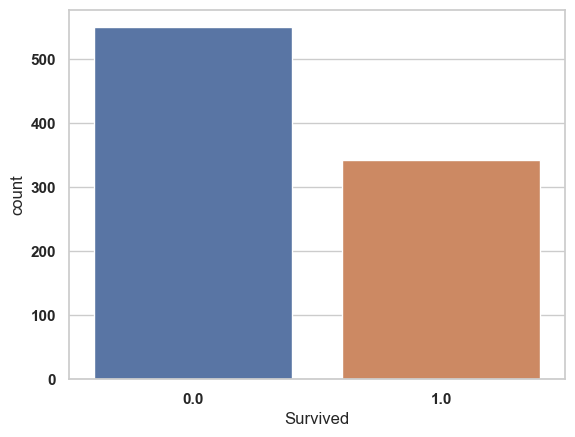

In [17]:
sns.countplot(data=train,x=df['Survived'])
plt.show()

In [18]:
correlate=test.corr().abs().unstack().sort_values(ascending=False).reset_index().rename(columns={'level_0':'Column1','level_1':'Column2',0:'Correlation'}).iloc[1::2]
correlate

,Column1,Column2,Correlation
1,Pclass,Pclass,1.000000
3,SibSp,SibSp,1.000000
5,Fare,Fare,1.000000
7,Pclass,Fare,0.577488
9,Age,Pclass,0.526789
11,Fare,Age,0.345352
13,SibSp,Parch,0.306895
15,Parch,Fare,0.230409
17,Fare,SibSp,0.172031
19,Age,SibSp,0.082493


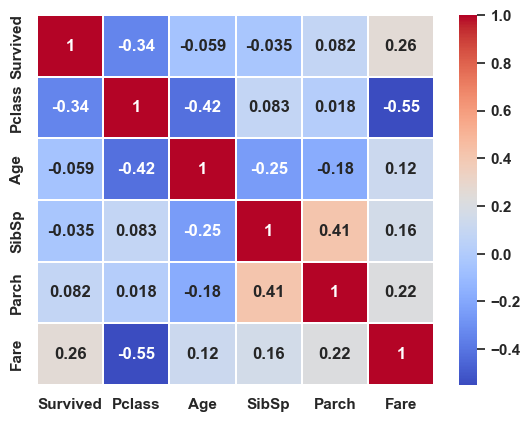

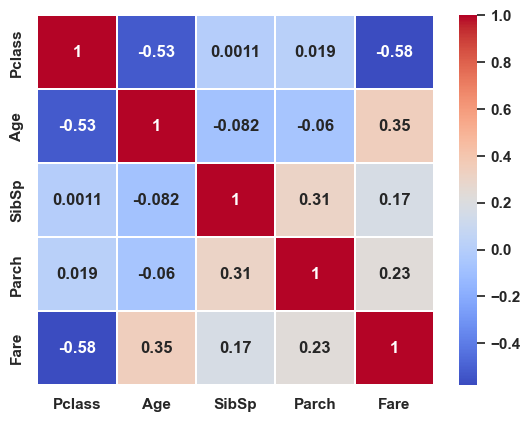

In [19]:
sns.heatmap(train.drop(['PassengerId'],axis=1).corr(),annot=True,cmap='coolwarm',linewidth=0.1,linecolor='white')
plt.show()
sns.heatmap(test.drop(['PassengerId'],axis=1).corr(),annot=True,cmap='coolwarm',linewidth=0.1,linecolor='white')
plt.show()

### Fare Feature Transformation

In [20]:
df['Fare']=pd.qcut(df['Fare'],13)

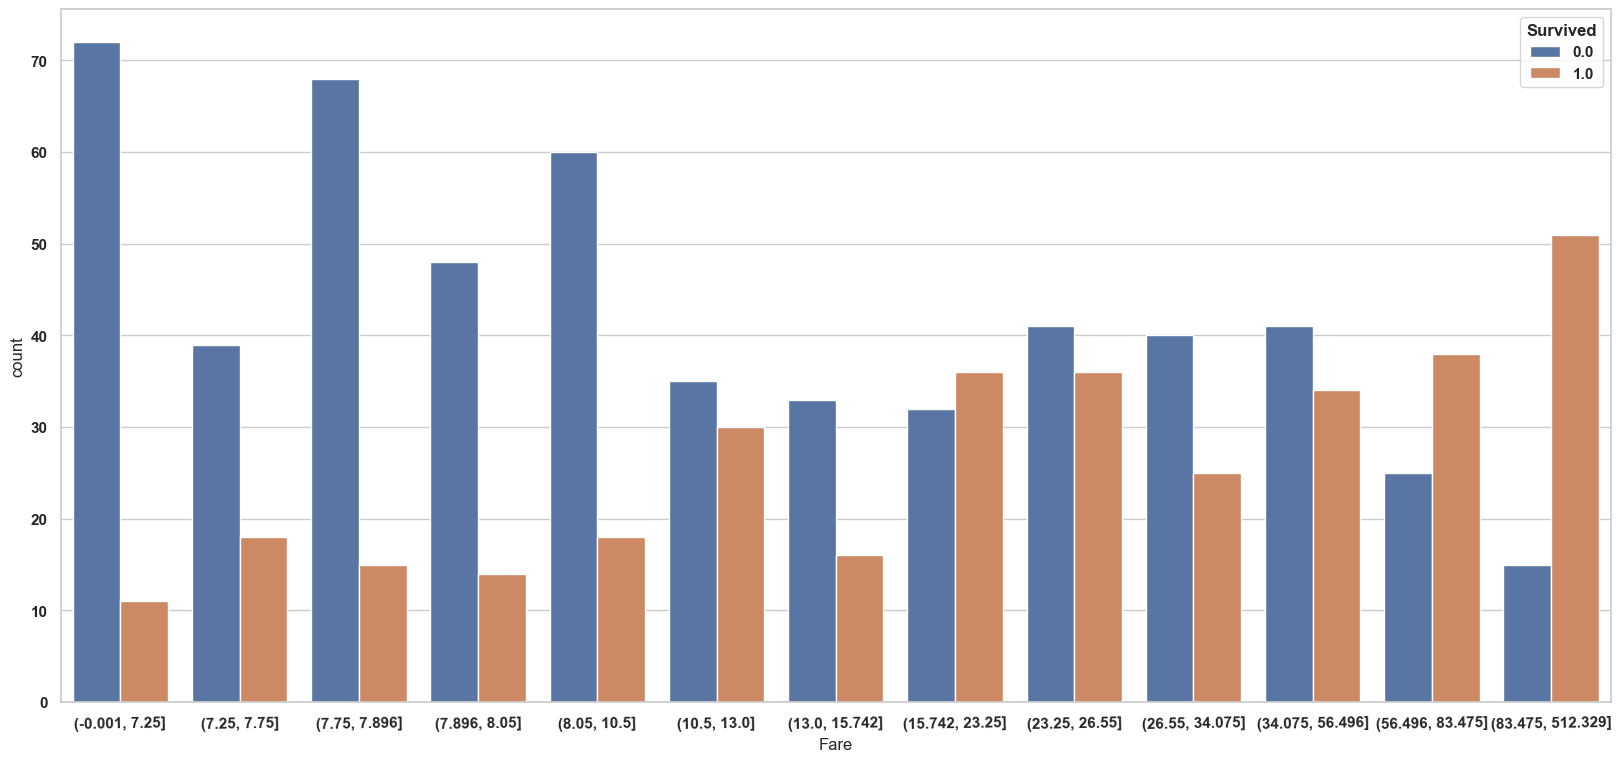

In [21]:
plt.figure(figsize=(20,9))
sns.countplot(data=df,x=df['Fare'],hue=df['Survived'])
plt.tick_params(axis='x',labelsize=11)
plt.xticks(rotation=1)
plt.show()

### Age Feature Transformation

In [22]:
df['Age']=pd.qcut(df['Age'],10)

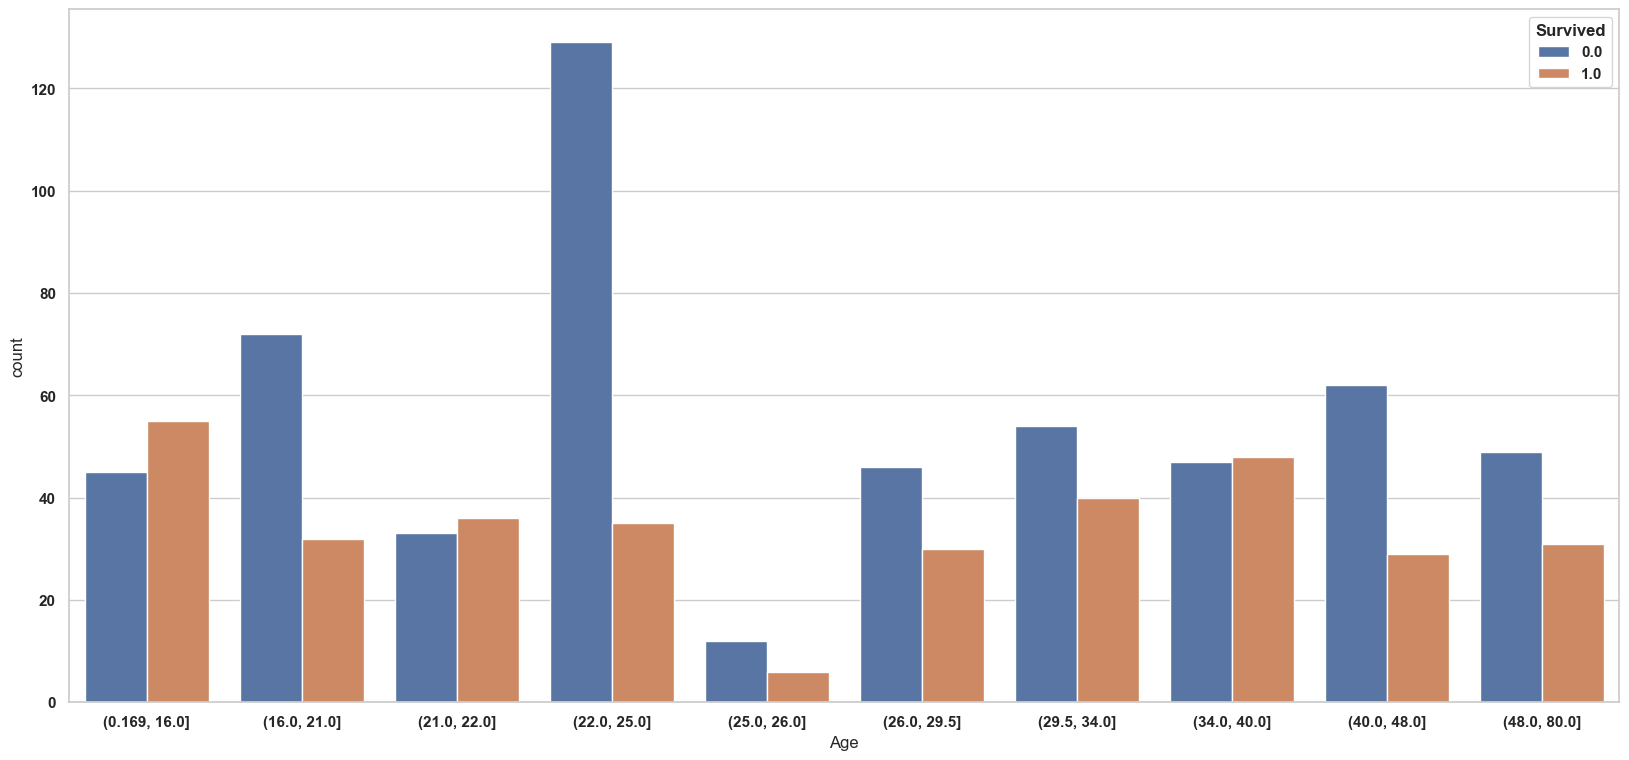

In [23]:
plt.figure(figsize=(20,9))
sns.countplot(data=train,x=df['Age'],hue=df['Survived'])
plt.show()

### Family Size Feature Transformation

In [24]:
df['Familysize']=df['Parch'] + df['SibSp'] + 1

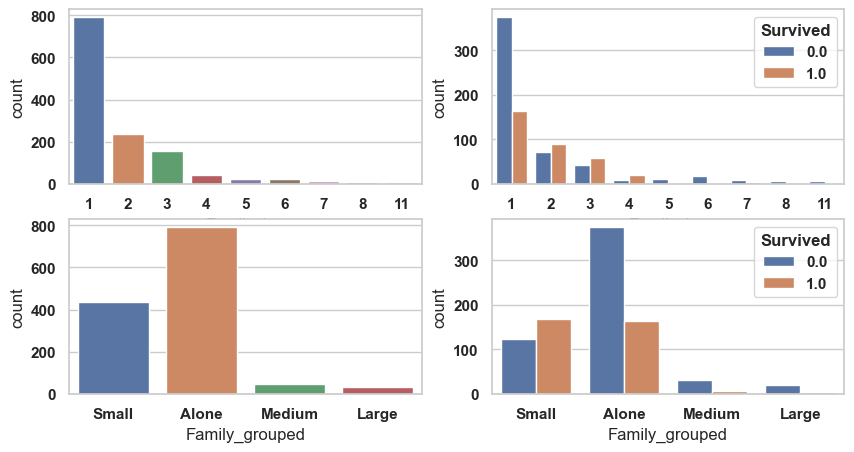

In [25]:
plt.figure(figsize=(10,5))
plt.subplot(2,2,1)
sns.countplot(data=df,x=df['Familysize'])

plt.subplot(2,2,2)
sns.countplot(data=df,x=df['Familysize'],hue=df['Survived'])

ranges={1:'Alone',2:'Small',3:'Small',4:'Small',5:'Medium',6:'Medium',7:'Large',8:'Large',11:'Large'}
df['Family_grouped']=df['Familysize'].map(ranges)
plt.subplot(2,2,3)
sns.countplot(data=df,x='Family_grouped')

plt.subplot(2,2,4)
sns.countplot(data=df,x='Family_grouped',hue=df['Survived'])
plt.show()

### Title Feature Engineering

In [26]:
df['Title']=df['Name'].str.split(',',expand=True)[1].str.split('.',expand=True)[0]
df['Title']=df['Title'].str.strip()

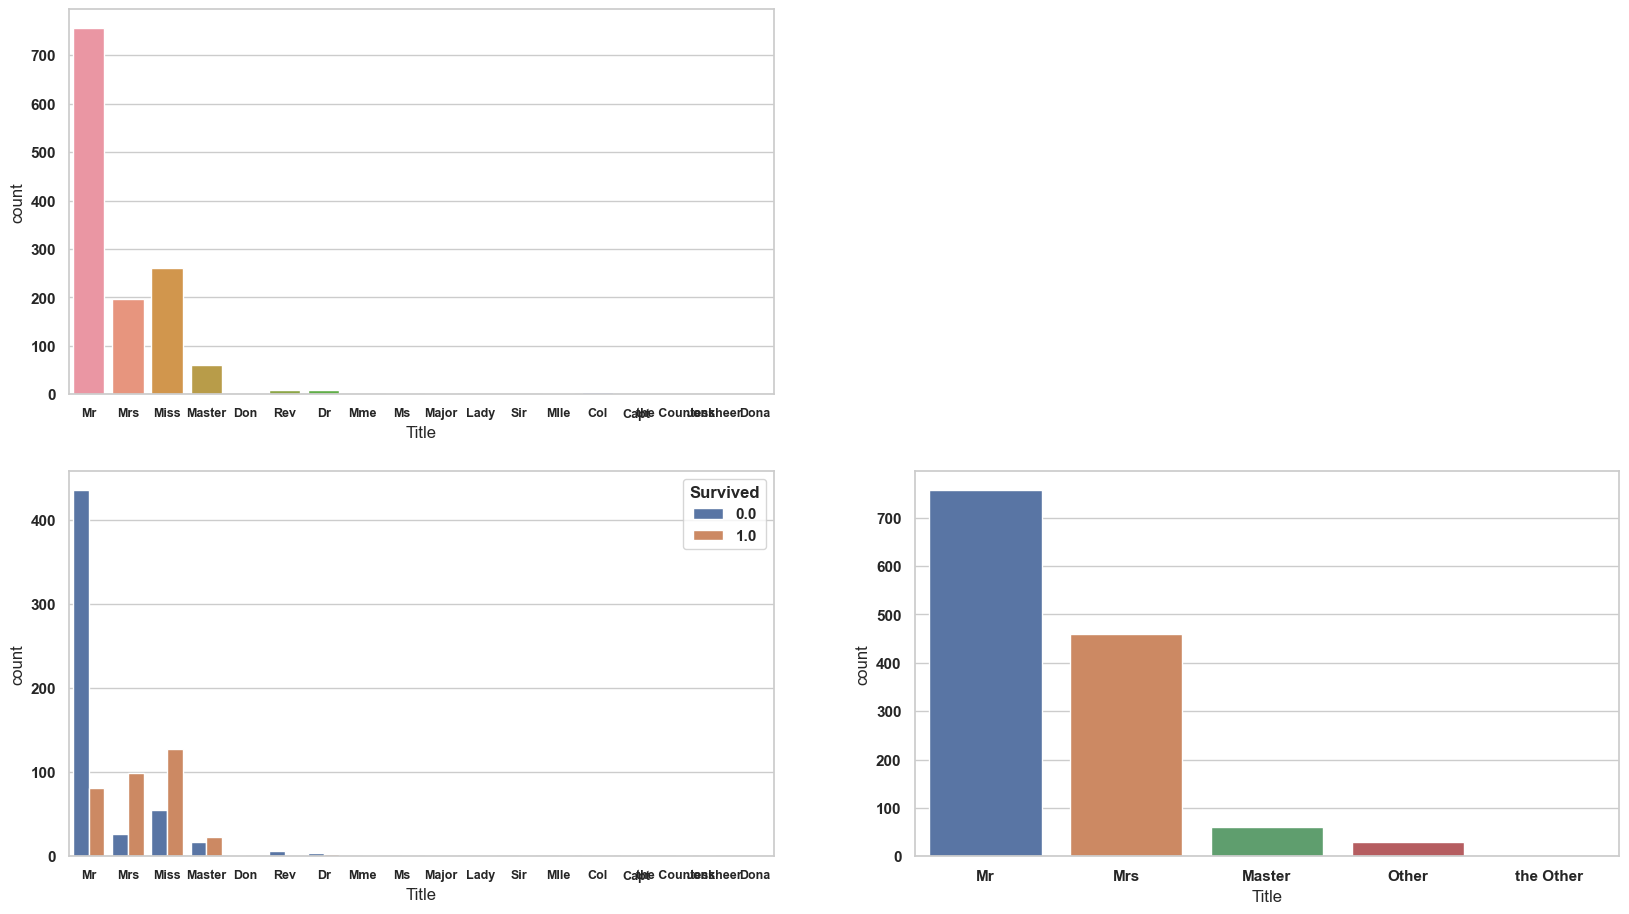

In [27]:
plt.figure(figsize=(20,11))

plt.subplot(2,2,1)
sns.countplot(data=df,x=df['Title'])
plt.tick_params(axis='x',labelsize=9)

plt.subplot(2,2,3)
sns.countplot(data=df,x=df['Title'],hue=df['Survived'])
plt.tick_params(axis='x',labelsize=9)

label={'Mr':'Mr','Sir':'Mr','Mrs':'Mrs','Miss':'Mrs','Ms':'Mrs','Lady':'Mrs','Master':'Master','Don':'Other','Rev':'Other','Dr':'Other','Mme':'Other','Major':'Other','Mlle':'Other','Col':'Other','Capt':'Other','the Countess':'the Other','Jonkheer':'Other','Dona':'Other'}
title_range=df['Title'].map(label)
plt.subplot(2,2,4)
sns.countplot(data=df,x=title_range)
plt.show()
df['Title']=title_range

### IS Married Feature Engineering

In [28]:
df['Is Married']=0
df['Is Married'].loc[df['Title']=='Mrs']=1

### Ticket Frequency Feature Engineering

In [29]:
df['Ticket Frequency']=df.groupby('Ticket')['Ticket'].transform('count')

### Family Feature Engineering

In [30]:
df['Family']=df['Name'].str.split(',',expand=True)[0]

In [31]:
train=df[:891]
test=df[891:]
x=train.drop(['Survived'],axis=1)
y=train['Survived']

In [32]:
common_family=train[train['Family'].isin(test['Family'])]['Family']
common_ticket=train[train['Ticket'].isin(test['Ticket'])]['Ticket']

In [33]:
family_rates=train[train['Family'].isin(common_family)].groupby('Family').median()['Survived']
ticket_rates=train[train['Ticket'].isin(common_ticket)].groupby('Ticket').median()['Survived']

In [34]:
surv_mean=train['Survived'].mean()
train['Family_survival_rate']=train['Family'].map(family_rates).fillna(surv_mean)
train['Family_survival_rate_NA']=train['Family'].map(family_rates).notnull().astype(int)
test['Family_survival_rate']=test['Family'].map(family_rates).fillna(surv_mean)
test['Family_survival_rate_NA']=test['Family'].map(family_rates).notna().astype(int)

train['Ticket_survival_rate']=train['Ticket'].map(ticket_rates).fillna(surv_mean)
train['Ticket_survival_rate_NA']=train['Ticket'].map(ticket_rates).notna().astype(int)
test['Ticket_survival_rate']=test['Ticket'].map(ticket_rates).fillna(surv_mean)
test['Ticket_survival_rate_NA']=test['Ticket'].map(ticket_rates).notna().astype(int)           

In [35]:
test=test.drop(['Survived'],axis=1)
df=pd.concat([train,test],axis=0)
df['Survival_rate']=(df['Family_survival_rate'] + df['Ticket_survival_rate'])/2
df['Survival_rate_NA']=(df['Ticket_survival_rate_NA'] + df['Family_survival_rate_NA'])/2

In [36]:
df=df.drop(['Name'],axis=1)
for i in df.select_dtypes(exclude=['int','float']).columns:
    df[i]=LabelEncoder().fit_transform(df[i])

In [37]:
cat_cols=['Pclass','Sex','Embarked','Deck','Title','Family_grouped']
df=pd.get_dummies(data=df,columns=cat_cols)

In [38]:
df=df.drop(['Family', 'Familysize','Parch', 'PassengerId', 'SibSp', 'Ticket','Ticket_survival_rate','Family_survival_rate','Ticket_survival_rate_NA','Family_survival_rate_NA'],axis=1)
test=df.drop(['Survived'],axis=1)[891:]
train=df[:891]
x=train.drop(['Survived'],axis=1)
y=train['Survived'].values

In [40]:
scaler=StandardScaler()
x=scaler.fit_transform(x)
test=scaler.transform(test)

In [47]:
# Overfit model is giving bad accuracy

tree=RandomForestClassifier(criterion='gini',n_estimators=1750,max_depth=7,min_samples_split=6,min_samples_leaf=6,max_features='auto',oob_score=True,random_state=0,n_jobs=-1,verbose=1)
model=tree.fit(x,y)
y_pred=model.predict(test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 1750 out of 1750 | elapsed:    2.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 1750 out of 1750 | elapsed:    0.3s finished


In [48]:
model.score(x,y)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 1750 out of 1750 | elapsed:    0.3s finished


0.867564534231201

In [49]:
submission_df=pd.DataFrame(columns=['PassengerId','Survived'])

In [50]:
submission_df['PassengerId']=ID
submission_df['Survived']=y_pred.astype(int)
submission_df.to_csv('C:\\Users\\kanis\\Desktop\\Dataset\\Titanic\\sub_titanic.csv',index=False,header=1)

In [51]:
submission_df

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
